# Lab: Wide and Deep Network Architectures

## 1. Preparation:

### 1.1 Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created):

&emsp; In this lab, we have chosen a dataset about Toyota used car. This dataset was published on Kaggle https://www.kaggle.com/datasets/mysarahmadbhat/toyota-used-car-listing by Mysar Ahmad Bhat. He thought this dataset could help his firend to determine how much should his old Toyota Car be sold. His thought give us an idea to process a wide and deep network model to help our customer to determine the price of used Toyota Car which they want to buy or sell.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('toyota.csv')
print(df.head())
print(df.info())

   model  year  price transmission  mileage fuelType  tax   mpg  engineSize
0   GT86  2016  16000       Manual    24089   Petrol  265  36.2         2.0
1   GT86  2017  15995       Manual    18615   Petrol  145  36.2         2.0
2   GT86  2015  13998       Manual    27469   Petrol  265  36.2         2.0
3   GT86  2017  18998       Manual    14736   Petrol  150  36.2         2.0
4   GT86  2017  17498       Manual    36284   Petrol  145  36.2         2.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738 entries, 0 to 6737
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         6738 non-null   object 
 1   year          6738 non-null   int64  
 2   price         6738 non-null   int64  
 3   transmission  6738 non-null   object 
 4   mileage       6738 non-null   int64  
 5   fuelType      6738 non-null   object 
 6   tax           6738 non-null   int64  
 7   mpg           6738 non-null   float64
 8   eng

&emsp; According to the publisher Mysar Ahmad Bhat, attribute 'model' represents Toyota model of used car, attribute 'year' represents registration year of used car, attribute 'price' represents price of used car in Euros, attribute 'transmission' represents gear box type of used car, attribute 'mileage' represents distance used of car, attribute 'fuelType' represents engine fuel of car, attribute 'tax' represents the road tax of car, attribute 'mpg' represent how many miles can this car be drived per galoon, attribute 'engineSize' represents the engine size of car in litres.

&emsp; Below we decide to check whether missing data exist or not:

(6738, 9)


<AxesSubplot:>

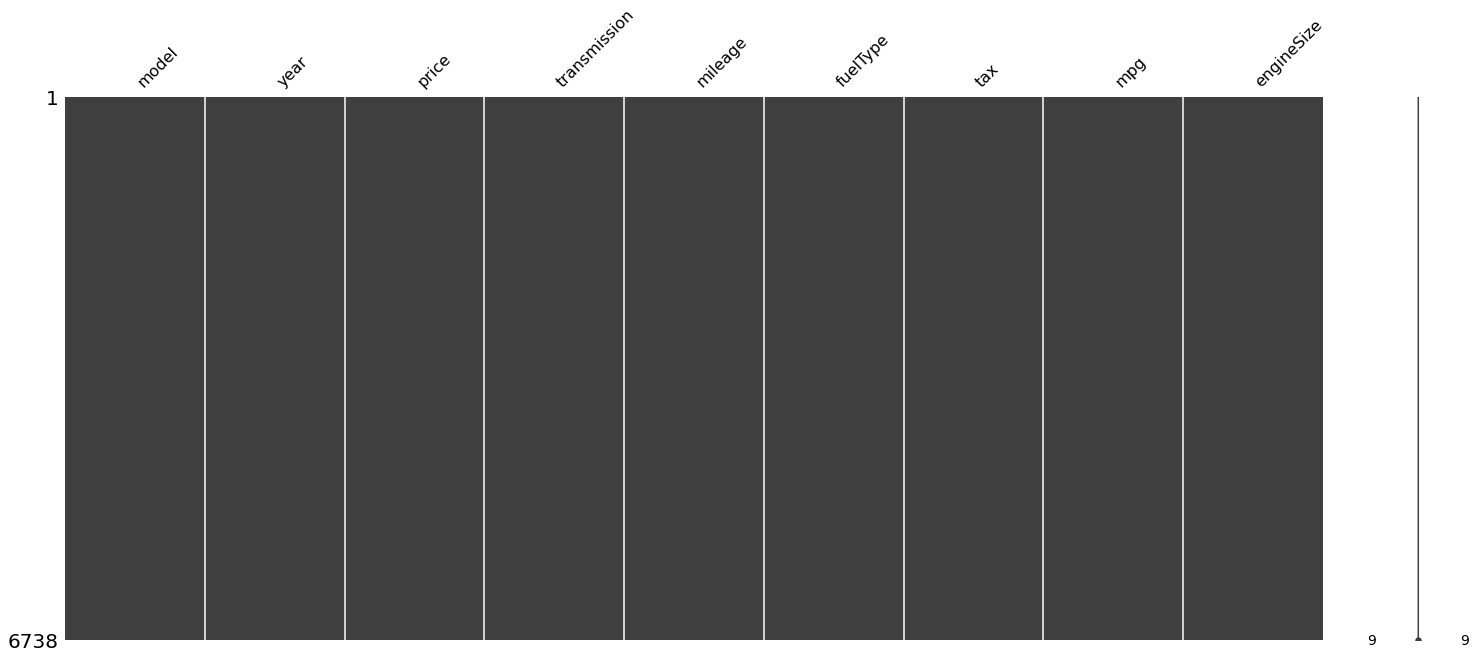

In [3]:
import missingno as mn

print(df.shape)
mn.matrix(df)

&emsp; It seems no missing data exist. However, data could be duplicated:

(6699, 9)


<AxesSubplot:>

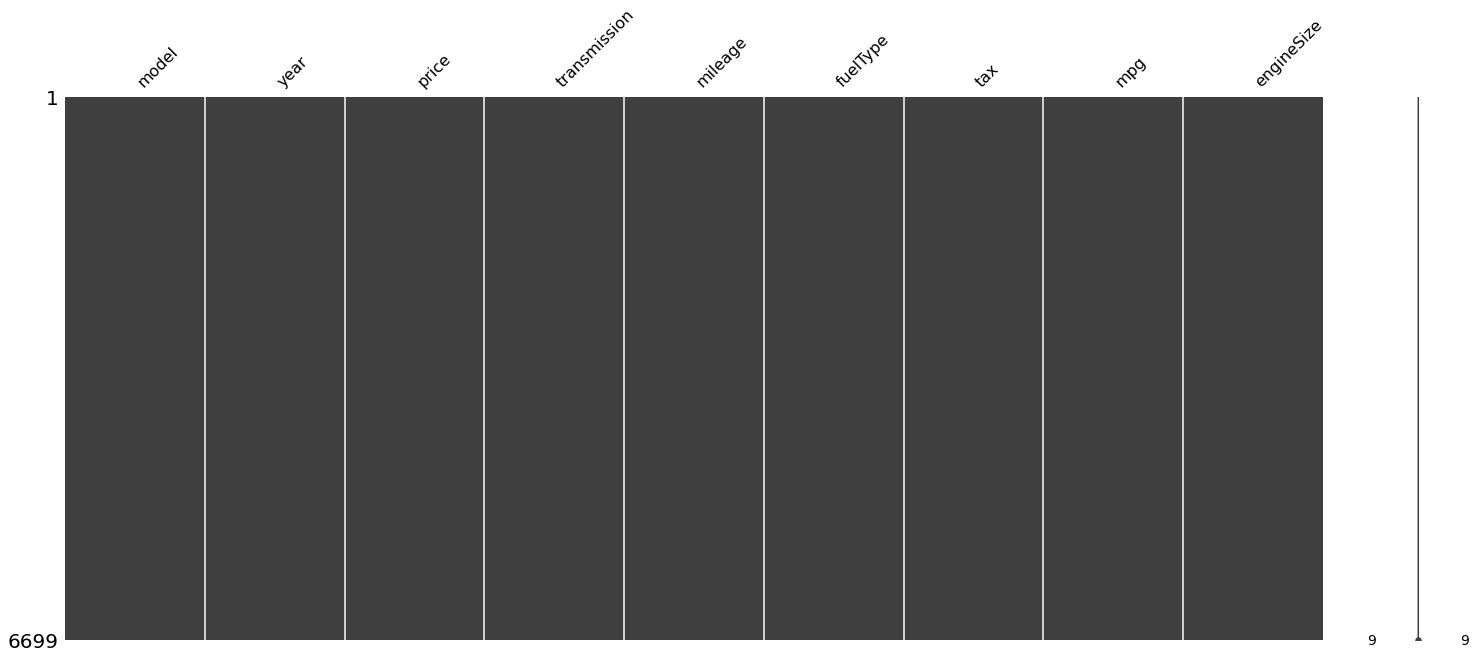

In [4]:
df = df.dropna()
df = df.drop_duplicates()
df = df.reset_index()
df = df.drop('index', axis= 1)
print(df.shape)
mn.matrix(df)

&emsp; Next, we decide to divide data into two classes according to the attribute 'price'. All the cars whose price less than mean value of all price should belong to class 0. And assign their attribute 'price_range' value as 0. All the cars whose price less than mean value of all price should belong to class 0. And assign their attribute 'price_range' value as 0. All the cars whose price equal to or greater than mean value of all price should belong to class 1. And assign their attribute 'price_range' value as 1:

In [5]:
df['price_range'] = pd.cut(df['price'], [0, df.price.mean(), 
                                         float("inf")],labels=[0, 1])
df.price_range = df.price_range.astype(np.int)
df['price_range'].value_counts()

0    4281
1    2418
Name: price_range, dtype: int64

&emsp; We decide to use package LabelEncoder to label all the string attributes which are model, year, transmission, and fuelType. Then use package StandardScaler to standardize attributes mileage, tax, mpg, and engineSize:

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

encoders = dict()
categorical_headers = ['model', 'year', 'transmission', 'fuelType']

for col in categorical_headers:
    encoders[col] = LabelEncoder()
    df[col] = encoders[col].fit_transform(df[col])

numeric_headers = ['mileage', 'tax', 'mpg', 'engineSize']

ss = StandardScaler()
df[numeric_headers] = ss.fit_transform(df[numeric_headers].values)

df = df.drop("price", axis=1)

df.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price_range
0,6,18,1,0.062771,3,2.305338,-1.694765,1.212155,1
1,6,19,1,-0.223708,3,0.682337,-1.694765,1.212155,1
2,6,17,1,0.239661,3,2.305338,-1.694765,1.212155,1
3,6,19,1,-0.426714,3,0.749962,-1.694765,1.212155,1
4,6,19,1,0.700990,3,0.682337,-1.694765,1.212155,1


### 1.2 Identify groups of features in your data that should be combined into cross-product features. Provide justification for why these features should be crossed (or why some features should not be crossed):

&emsp; In this part, we decide to combine model and year, model and transmission, model and fuelType into cross-product features.

&emsp; For model and year, even if the customer has determined what model to buy, they may still struggle with year, because everyone wants to buy the latest model rather than the old model. For example, if people have the opportunity to choose the same 2021 and 2011 car, even if the mileage is the same and the 2011 car is $3,000 cheaper than the 2021 car, people still hesitate to choose between the two cars.

&emsp; For model and transmission, even if the customer has determined what model to buy, they may still struggle with transmission. For example, a model, named Camry, is one of the most affordable car for college students. Students who have enough budget and are not very confident in theirselves driving skill may choose Automatic car, yet some other students who do not have enough budget may choose Manual or Semi-Auto car. Therefore, cross-product feature of model and transmission could help this kind of customer to determine what transmission is most suitable for them.

&emsp; For model and fuelType, just like the previous cross-product feature, customers may struggle with fuelType even if the model is determined. For example, customers who live in Texas may consider Petrol car because fuel price is affordable in Texas, yet customers who live in California may prefer Hybird car since the fuel price is high.

In [7]:
cross_columns = [['model','year'],
                 ['model','transmission'],
                 ['model','fuelType']]

cross_col_df_names = []
for cols_list in cross_columns:
    enc = LabelEncoder()
    
    X_crossed = df[cols_list].astype(str).apply(lambda x: '_'.join(x), axis=1)
    cross_col_name = '_'.join(cols_list)
    enc.fit(X_crossed)
    df[cross_col_name] = enc.transform(X_crossed)
    cross_col_df_names.append(cross_col_name) 
    
cross_col_df_names

['model_year', 'model_transmission', 'model_fuelType']

In [8]:
df.head()

,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price_range,model_year,model_transmission,model_fuelType
0,6,18,1,0.062771,3,2.305338,-1.694765,1.212155,1,134,34,35
1,6,19,1,-0.223708,3,0.682337,-1.694765,1.212155,1,135,34,35
2,6,17,1,0.239661,3,2.305338,-1.694765,1.212155,1,133,34,35
3,6,19,1,-0.426714,3,0.749962,-1.694765,1.212155,1,135,34,35
4,6,19,1,0.700990,3,0.682337,-1.694765,1.212155,1,135,34,35


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6699 entries, 0 to 6698
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   model               6699 non-null   int64  
 1   year                6699 non-null   int64  
 2   transmission        6699 non-null   int64  
 3   mileage             6699 non-null   float64
 4   fuelType            6699 non-null   int64  
 5   tax                 6699 non-null   float64
 6   mpg                 6699 non-null   float64
 7   engineSize          6699 non-null   float64
 8   price_range         6699 non-null   int64  
 9   model_year          6699 non-null   int64  
 10  model_transmission  6699 non-null   int64  
 11  model_fuelType      6699 non-null   int64  
dtypes: float64(4), int64(8)
memory usage: 628.2 KB


### 1.3 Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance:

&emsp; We will use accuracy to evaluate our algorithm’s performance. In this case of predict price of used car, the function of correctly recommending and pricing used cars according to customers' personal preferences will directly affect customers' purchase intention and final purchase result. The consequence of the model fail to provide an accurate prediction of the price range is that the merchant may lost potential orders. What's more, the customers have already wasted their time, but still may not be able to obtain a suitable car for themselves. This is an unacceptable result for both sides. Therefore, the importance of the prediction accuracy of the model is essential, and the accuracy is taken as the ultimate standard to determine the performance of the model.

### 1.4 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice:

&emsp; As we already divided data into two classes according to the attribute 'price'. The number of instances which belong to class 0 is 4281. And the number of instances which belong to class 1 is 2418. It seems our dataset is unbalanced. An imbalance dataset may result in potential risks when we train model. In order to eliminate the negetive influence of imbalance, we decide to import train_test_split package to perform the train and test partitioning of the dataset. Because train_test_split package is able to maintain the percentage of each class in the dataset and randomly split into train and test datasets with 8:2 ratio.

In [10]:
from sklearn.model_selection import train_test_split

y = df['price_range']
X = df.drop('price_range', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size = 0.2, random_state = 7)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5359, 11), (1340, 11), (5359,), (1340,))

## 2. Modeling:

### 2.1 Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data:

&emsp; In this part we should first create three combined wide and deep networks using Keras. The first combined wide and deep networks will be created below. In this first combined wide and deep networks, cross columns will include all the cross-product features we mentioned previously. They are model_year, model_transmission, and model_fuelType cross-product feature:

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from sklearn import metrics as mt
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate

In [12]:
X_train_cat = X_train[categorical_headers].to_numpy() 
X_test_cat = X_test[categorical_headers].to_numpy()

X_train_num = X_train[numeric_headers].to_numpy() 
X_test_num = X_test[numeric_headers].to_numpy()

X_train_crossed = X_train[cross_col_df_names].to_numpy() 
X_test_crossed = X_test[cross_col_df_names].to_numpy()

crossed_outputs = []
all_deep_branch_outputs = []

input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):
    N = max(X_train[col].max(),X_test[col].max())+1
    x = tf.gather(input_crossed, idx, axis=1)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    crossed_outputs.append(x)

wide_branch = concatenate(crossed_outputs, name='wide_concat')


input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers):
    N = max(X_train[col].max(),X_test[col].max())+1
    x = tf.gather(input_cat, idx, axis=1)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    all_deep_branch_outputs.append(x)
    

input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=10, activation='relu',name='num_1')(input_num)
all_deep_branch_outputs.append(x_dense)


deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=10,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model_1 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)

2022-11-20 15:40:31.531071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


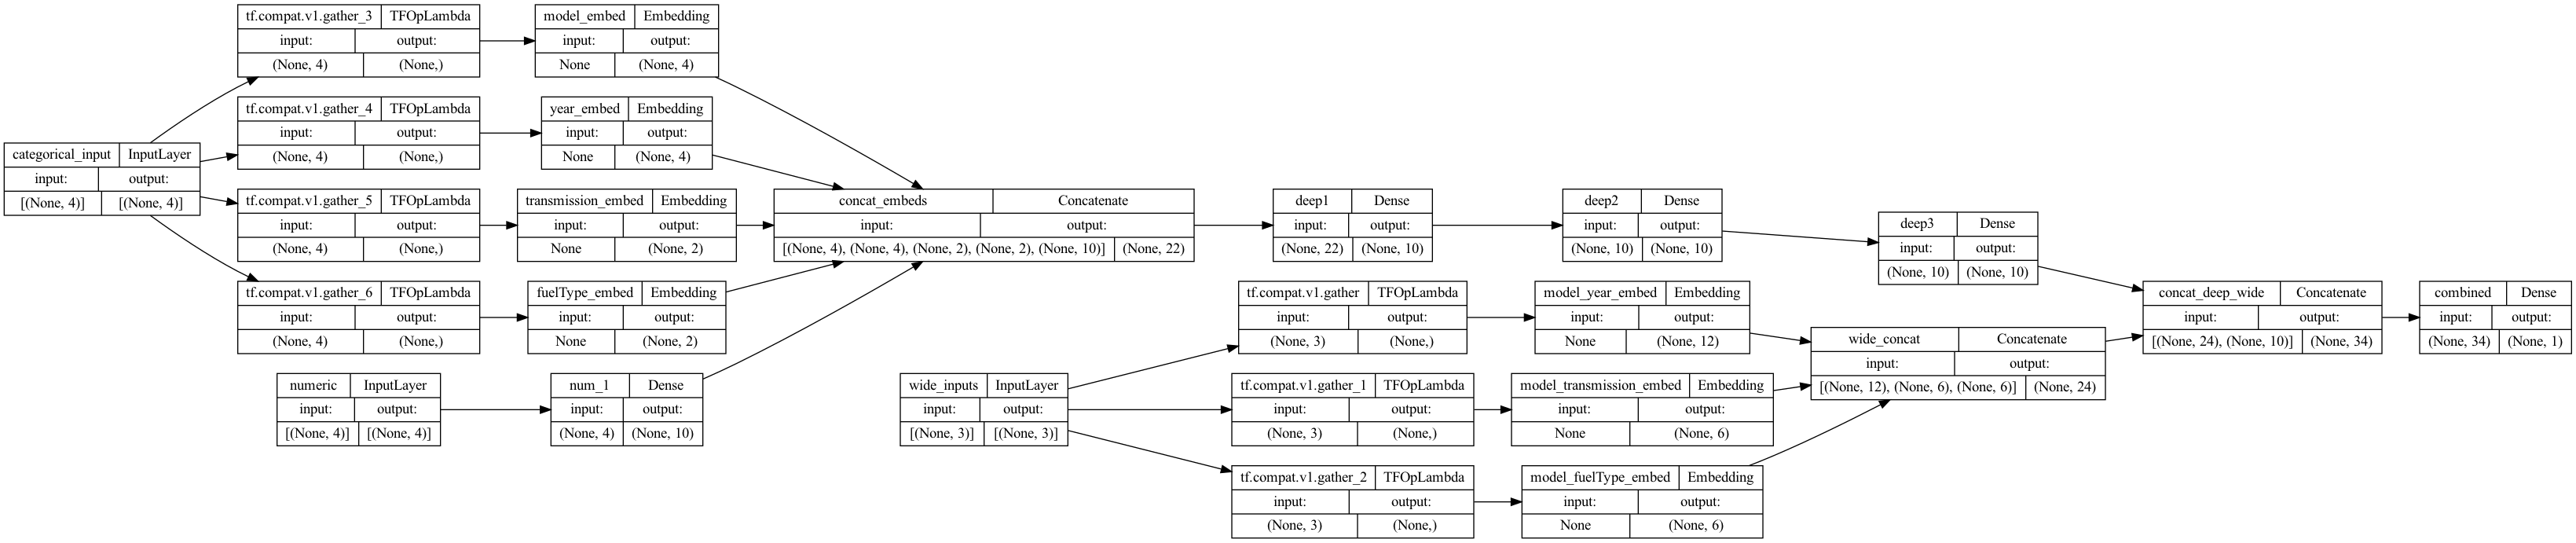

In [13]:
plot_model(
    model_1, to_file='model_1.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [14]:
%%time

model_1.compile(optimizer='Adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'accuracy'])

history = model_1.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/15
168/168 [==============================] - 1s 1ms/step - loss: 0.1596 - mean_squared_error: 0.1596 - accuracy: 0.8772 - val_loss: 0.0732 - val_mean_squared_error: 0.0732 - val_accuracy: 0.9261
Epoch 2/15
168/168 [==============================] - 0s 773us/step - loss: 0.0579 - mean_squared_error: 0.0579 - accuracy: 0.9360 - val_loss: 0.0422 - val_mean_squared_error: 0.0422 - val_accuracy: 0.9470
Epoch 3/15
168/168 [==============================] - 0s 748us/step - loss: 0.0440 - mean_squared_error: 0.0440 - accuracy: 0.9369 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_accuracy: 0.9485
Epoch 4/15
168/168 [==============================] - 0s 773us/step - loss: 0.0404 - mean_squared_error: 0.0404 - accuracy: 0.9457 - val_loss: 0.0353 - val_mean_squared_error: 0.0353 - val_accuracy: 0.9493
Epoch 5/15
168/168 [==============================] - 0s 794us/step - loss: 0.0388 - mean_squared_error: 0.0388 - accuracy: 0.9448 - val_loss: 0.0344 - val_mean_squared_error: 0.

In [15]:
yhat = np.round(model_1.predict([X_test_crossed,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

42/42 [==============================] - 0s 407us/step
[[860  15]
 [ 50 415]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       875
           1       0.97      0.89      0.93       465

    accuracy                           0.95      1340
   macro avg       0.96      0.94      0.95      1340
weighted avg       0.95      0.95      0.95      1340



Text(0.5, 0, 'epochs')

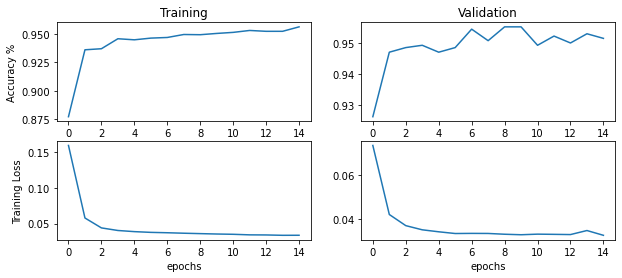

In [16]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

&emsp; The second combined wide and deep networks will be created below. In this second combined wide and deep networks, cross_columns only include model_transmission and model_fuelType:

In [17]:
cross_col_df_names_2 = cross_col_df_names[1:]

X_train_crossed_2 = X_train[cross_col_df_names_2].to_numpy() 
X_test_crossed_2 = X_test[cross_col_df_names_2].to_numpy()

crossed_outputs = []

input_crossed = Input(shape=(X_train_crossed_2.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names_2):
    N = max(X_train[col].max(),X_test[col].max())+1
    x = tf.gather(input_crossed, idx, axis=1)
    x = Embedding(input_dim=N, output_dim=int(np.sqrt(N)), input_length=1, name=col+'_embed')(x)
    crossed_outputs.append(x)

wide_branch = concatenate(crossed_outputs, name='wide_concat')

final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model_2 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)

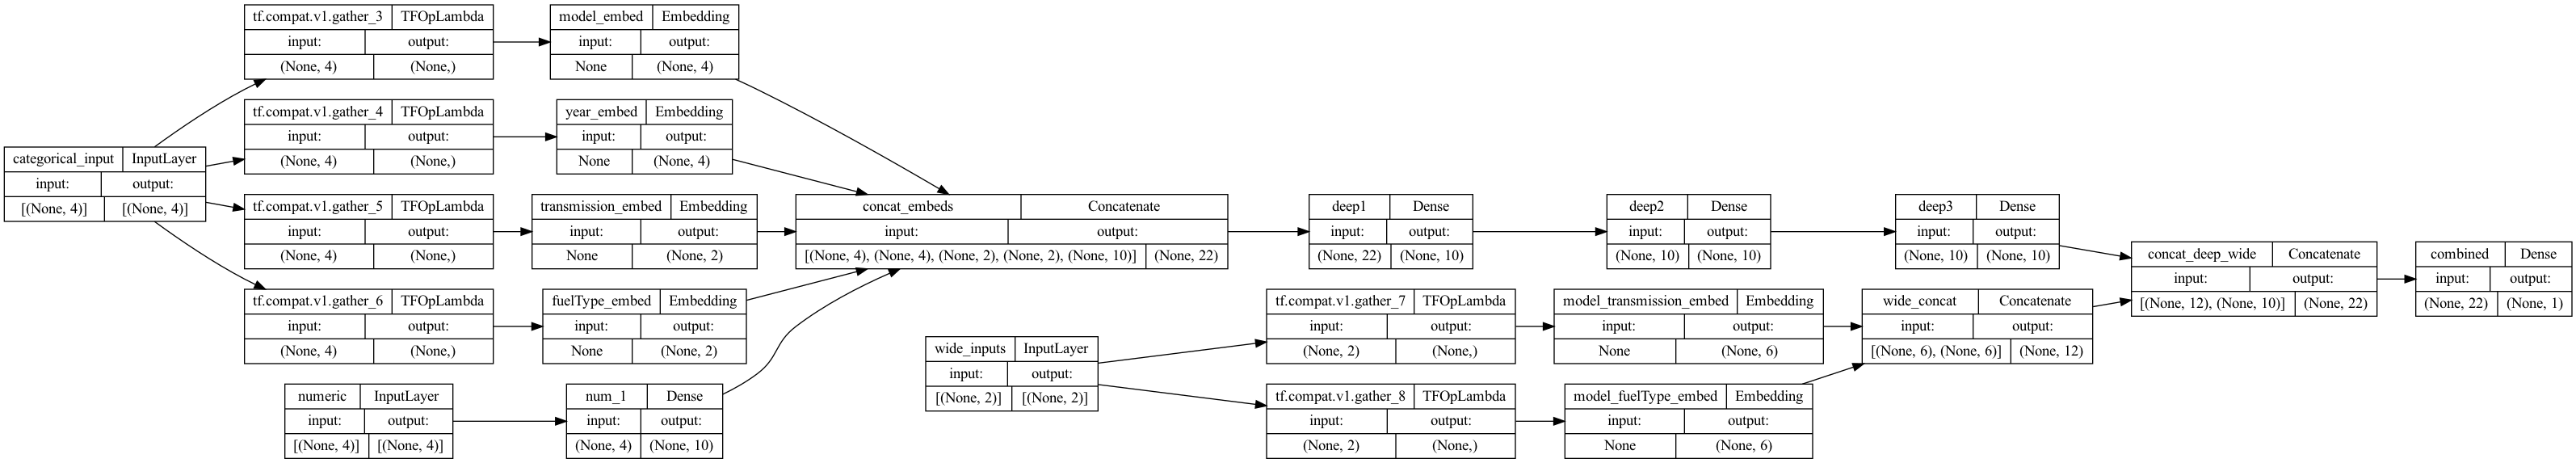

In [18]:
plot_model(
    model_2, to_file='model_2.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [19]:
%%time

model_2.compile(optimizer='Adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'accuracy'])

history = model_2.fit([X_train_crossed_2,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed_2,X_test_cat,X_test_num],y_test))

Epoch 1/15
168/168 [==============================] - 1s 1ms/step - loss: 0.0617 - mean_squared_error: 0.0617 - accuracy: 0.9440 - val_loss: 0.0379 - val_mean_squared_error: 0.0379 - val_accuracy: 0.9485
Epoch 2/15
168/168 [==============================] - 0s 768us/step - loss: 0.0392 - mean_squared_error: 0.0392 - accuracy: 0.9479 - val_loss: 0.0347 - val_mean_squared_error: 0.0347 - val_accuracy: 0.9478
Epoch 3/15
168/168 [==============================] - 0s 766us/step - loss: 0.0374 - mean_squared_error: 0.0374 - accuracy: 0.9483 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_accuracy: 0.9530
Epoch 4/15
168/168 [==============================] - 0s 765us/step - loss: 0.0369 - mean_squared_error: 0.0369 - accuracy: 0.9489 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_accuracy: 0.9530
Epoch 5/15
168/168 [==============================] - 0s 745us/step - loss: 0.0356 - mean_squared_error: 0.0356 - accuracy: 0.9528 - val_loss: 0.0326 - val_mean_squared_error: 0.

In [20]:
yhat = np.round(model_2.predict([X_test_crossed_2,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

42/42 [==============================] - 0s 448us/step
[[862  13]
 [ 45 420]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       875
           1       0.97      0.90      0.94       465

    accuracy                           0.96      1340
   macro avg       0.96      0.94      0.95      1340
weighted avg       0.96      0.96      0.96      1340



Text(0.5, 0, 'epochs')

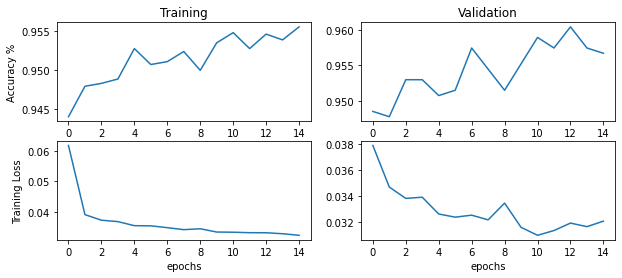

In [21]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

&emsp; According to the figures above, the accuracy of two cross-product features with model_transmission and model_fuelType is slightly greater than three cross-product features.

&emsp; The third combined wide and deep networks will be created below. In this third combined wide and deep networks, we not only just use two cross-product features in cross_columns, but also assign 5 layers in deep layer:

In [22]:
layer_numbers = 5

deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
for index in range(layer_numbers):
    deep_number = index + 1
    deep_branch = Dense(units=10,activation='relu', name=f'deep{deep_number}')(deep_branch)

final_branch = concatenate([wide_branch, deep_branch], name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model_3 = Model(inputs=[input_crossed,input_cat,input_num], outputs=final_branch)

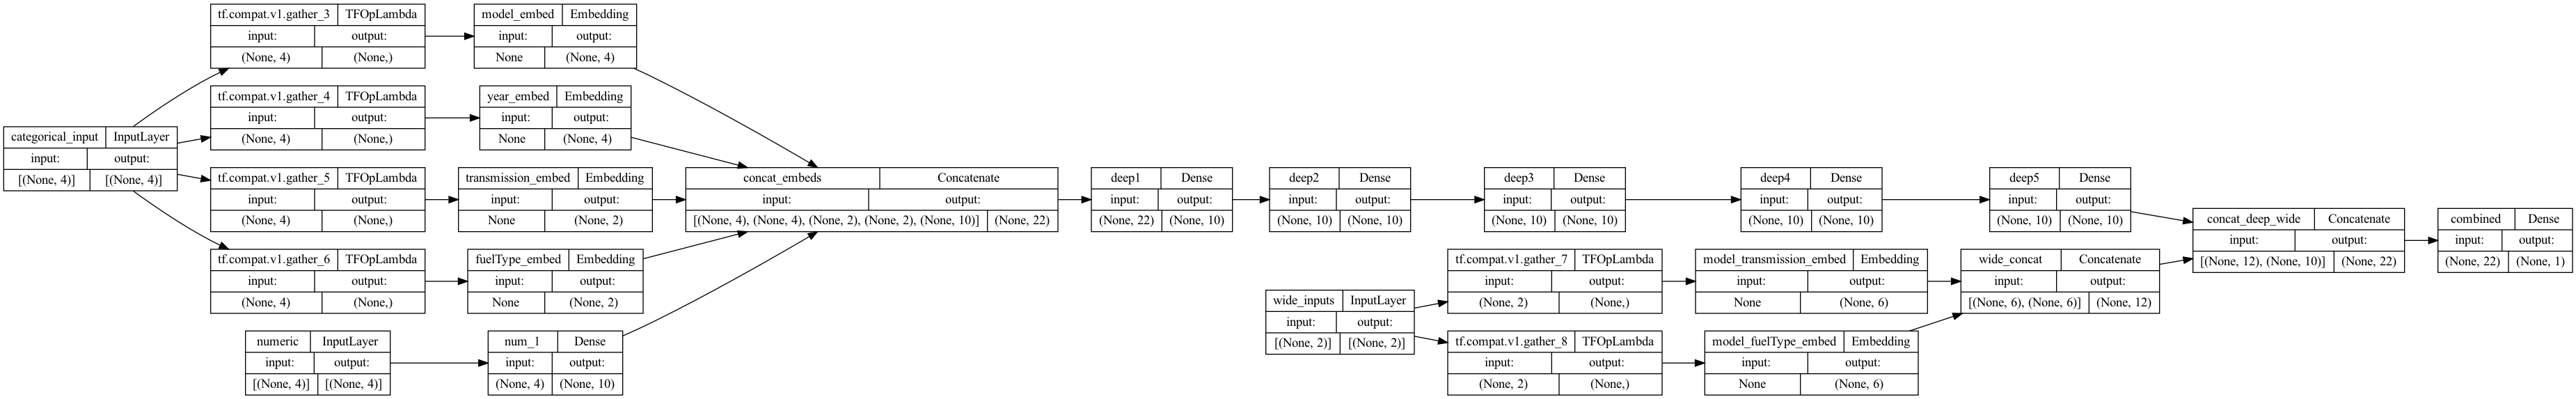

In [23]:
plot_model(
    model_3, to_file='model_3.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [24]:
%%time

model_3.compile(optimizer='Adam',
              loss='mean_squared_error',
              metrics=['mean_squared_error', 'accuracy'])

history = model_3.fit([X_train_crossed_2,X_train_cat,X_train_num],
                    y_train, 
                    epochs=15, 
                    batch_size=32, 
                    verbose=1, 
                    validation_data = ([X_test_crossed_2,X_test_cat,X_test_num],y_test))

Epoch 1/15
168/168 [==============================] - 1s 1ms/step - loss: 0.1298 - mean_squared_error: 0.1298 - accuracy: 0.8203 - val_loss: 0.0432 - val_mean_squared_error: 0.0432 - val_accuracy: 0.9455
Epoch 2/15
168/168 [==============================] - 0s 812us/step - loss: 0.0414 - mean_squared_error: 0.0414 - accuracy: 0.9446 - val_loss: 0.0335 - val_mean_squared_error: 0.0335 - val_accuracy: 0.9545
Epoch 3/15
168/168 [==============================] - 0s 789us/step - loss: 0.0373 - mean_squared_error: 0.0373 - accuracy: 0.9498 - val_loss: 0.0318 - val_mean_squared_error: 0.0318 - val_accuracy: 0.9552
Epoch 4/15
168/168 [==============================] - 0s 782us/step - loss: 0.0365 - mean_squared_error: 0.0365 - accuracy: 0.9504 - val_loss: 0.0315 - val_mean_squared_error: 0.0315 - val_accuracy: 0.9597
Epoch 5/15
168/168 [==============================] - 0s 800us/step - loss: 0.0351 - mean_squared_error: 0.0351 - accuracy: 0.9524 - val_loss: 0.0313 - val_mean_squared_error: 0.

In [25]:
yhat = np.round(model_3.predict([X_test_crossed_2,X_test_cat,X_test_num]))
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))

42/42 [==============================] - 0s 434us/step
[[865  10]
 [ 51 414]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       875
           1       0.98      0.89      0.93       465

    accuracy                           0.95      1340
   macro avg       0.96      0.94      0.95      1340
weighted avg       0.96      0.95      0.95      1340



Text(0.5, 0, 'epochs')

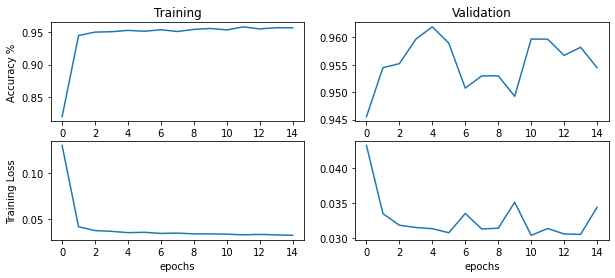

In [26]:
%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['accuracy'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_accuracy'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

&emsp; According to the figures above, it seems that the accuracy of five deep layers is greater than the accuracy of three deep layers with the same cross-product features.

&emsp; Compare these different networks:

42/42 [==============================] - 0s 434us/step


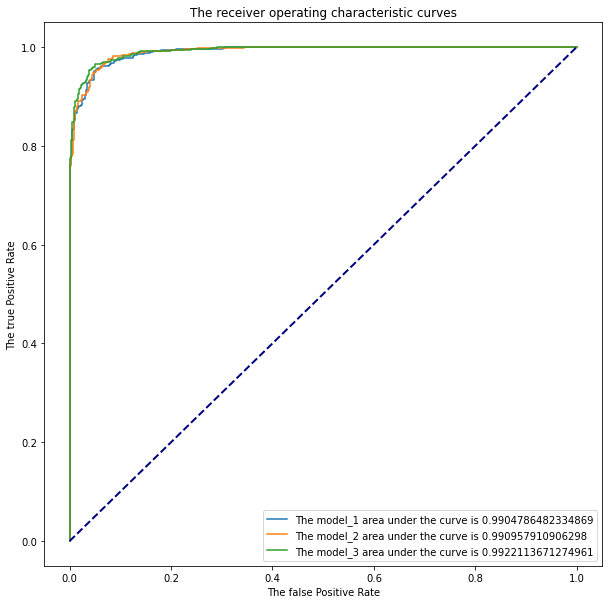

In [27]:
from sklearn.metrics import roc_curve, auc

y_pred_1 = model_1.predict([X_test_crossed,X_test_cat,X_test_num]).ravel()
y_pred_2 = model_2.predict([X_test_crossed_2,X_test_cat,X_test_num]).ravel()
y_pred_3 = model_3.predict([X_test_crossed_2,X_test_cat,X_test_num]).ravel()

fpr_list = []
tpr_list = []
fpr_1, tpr_1, _ = roc_curve(y_true = y_test, y_score = y_pred_1)
fpr_2, tpr_2, _ = roc_curve(y_true = y_test, y_score = y_pred_2)
fpr_3, tpr_3, _ = roc_curve(y_true = y_test, y_score = y_pred_3)
fpr_list.append(fpr_1)
fpr_list.append(fpr_2)
fpr_list.append(fpr_3)
tpr_list.append(tpr_1)
tpr_list.append(tpr_2)
tpr_list.append(tpr_3)

auc_list = []
auc_1 = auc(fpr_1, tpr_1)
auc_2 = auc(fpr_2, tpr_2)
auc_3 = auc(fpr_3, tpr_3)
auc_list.append(auc_1)
auc_list.append(auc_2)
auc_list.append(auc_3)

plt.figure(figsize=(10,10))
for index in range(3):
    name_number = index + 1
    plt.plot(fpr_list[index], tpr_list[index], label = f'The model_{name_number} area under the curve is {auc_list[index]}')

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("The false Positive Rate")
plt.ylabel("The true Positive Rate")
plt.title("The receiver operating characteristic curves")
plt.legend(loc="lower right")
plt.show()


&emsp; From the figure above, we can conduct that the model_3 which only has two cross-product features and obtains five deep layers is the best.

### 2.2 Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly:

In [28]:
from sklearn.model_selection import KFold

split_numbers = 10
kf = KFold(n_splits=split_numbers, shuffle=True, random_state=7)
X_crossed = X[cross_col_df_names_2].to_numpy()
X_cat = X[categorical_headers].to_numpy()
X_num = X[numeric_headers].to_numpy()

def computeCrossValidation():
    for model_no,deep_branch in enumerate(deep_branches):
        accuracy_score_list = []
        for train_index, test_index in kf.split(X, y):
            X_train_crossed, X_test_crossed = X_crossed[train_index], X_crossed[test_index]
            X_train_cat, X_test_cat = X_cat[train_index], X_cat[test_index]
            X_train_num, X_test_num = X_num[train_index], X_num[test_index]
            y_train, y_test = y[train_index], y[test_index]

            final_branch = concatenate([wide_branch, deep_branch], axis=1)
            final_branch = Dense(units=1, kernel_initializer=tf.keras.initializers.GlorotUniform())(final_branch)
            model = Model(inputs=[input_crossed, input_cat, input_num], outputs=final_branch)
            model.compile(optimizer='adam', loss= 'mean_squared_error', metrics=['mean_squared_error', 'accuracy'])
            model.fit([X_train_crossed,X_train_cat,X_train_num], y_train, epochs=15, batch_size=32, 
                      verbose=0, validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))
            y_hat = model.predict([X_test_crossed,X_test_cat,X_test_num])
            accuracy_score_list.append(mt.accuracy_score(y_test,np.round(y_hat)))    
        cross_validation_list.append(sum(accuracy_score_list)/split_numbers)

&emsp; Three layers in deep branch of the network:

In [29]:
deep_branches = []
cross_validation_list =[]
layer_numbers = 3

deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
for index in range(layer_numbers):
    deep_number = index + 1
    deep_branch = Dense(units=10,activation='relu', name=f'deep{deep_number}')(deep_branch)
    deep_branches.append(deep_branch)

computeCrossValidation()
cross_validation_list

21/21 [==============================] - 0s 423us/step


[0.9508877138968833, 0.9541726345849229, 0.9550674876737387]

&emsp; Four layers in deep branch of the network:

In [30]:
deep_branches = []
cross_validation_list =[]
layer_numbers = 4

deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
for index in range(layer_numbers):
    deep_number = index + 1
    deep_branch = Dense(units=10,activation='relu', name=f'deep{deep_number}')(deep_branch)
    deep_branches.append(deep_branch)

computeCrossValidation()
cross_validation_list

21/21 [==============================] - 0s 429us/step


[0.9502909220712578,
 0.9552169645048301,
 0.9550679338732347,
 0.9589489770876558]

&emsp; Five layers in deep branch of the network:

In [31]:
deep_branches = []
cross_validation_list =[]
layer_numbers = 5

deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
for index in range(layer_numbers):
    deep_number = index + 1
    deep_branch = Dense(units=10,activation='relu', name=f'deep{deep_number}')(deep_branch)
    deep_branches.append(deep_branch)

computeCrossValidation()
cross_validation_list

21/21 [==============================] - 0s 437us/step


[0.9510380831269659,
 0.9558146487294469,
 0.9568580862503623,
 0.9592479307498382,
 0.9601416683399148]

&emsp; According to the accuracy results shown above, the performance of network will increase as the number of layers in the deep branch increases. And we can conduct that the five layers in the deep branch of the network perform superiorly.

### 2.3 Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models:

&emsp; In this part, we will implement MLP in our wide and deep network first. Then compare the performance of network with MLP and the performance of network with our model_3.

&emsp; MLP Implementation:

In [32]:
from sklearn.neural_network import MLPClassifier

model_MLP = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10,10,10),solver='adam',batch_size=32,max_iter=10,verbose=0)
model_MLP.fit(X_train,y_train)

y_pred_MLP = model_MLP.predict(X_test).ravel()
fpr_MLP, tpr_MLP, _ = roc_curve(y_test, y_pred_MLP)
auc_MLP = auc(fpr_MLP, tpr_MLP)

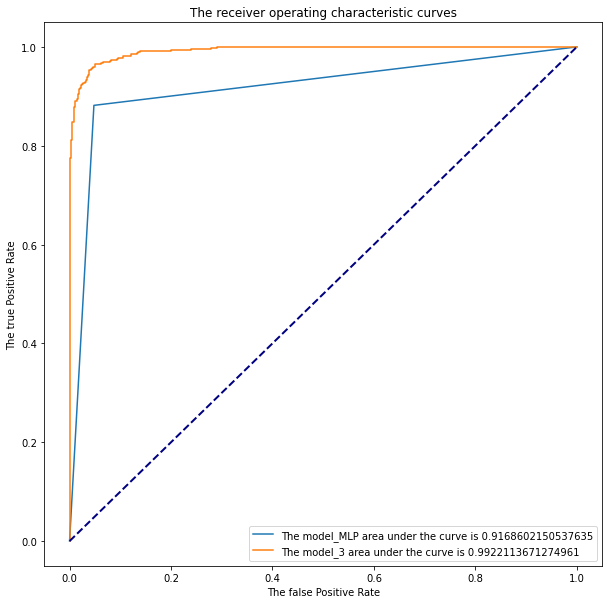

In [33]:
plt.figure(figsize=(10,10))

plt.plot(fpr_MLP, tpr_MLP, label = f'The model_MLP area under the curve is {auc_MLP}')
plt.plot(fpr_list[2], tpr_list[2], label = f'The model_3 area under the curve is {auc_list[2]}')

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("The false Positive Rate")
plt.ylabel("The true Positive Rate")
plt.title("The receiver operating characteristic curves")
plt.legend(loc="lower right")
plt.show()

&emsp; According to the receiver operating characteristic curve shown above, our model_3 occupies 99.2 percent of area, yet MLP model only occupies 91.6 percent of area. It is obvious that our model_3 is much better than MLP model.

## 3. Exceptional Work:

### Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data:

&emsp; In this part, we firstly using get_layer function of Model to get every categorical layer. Then, t-SNE method and PCA method are chosen to perform dimensionality reduction.

&emsp; Model get_layer:

210/210 [==============================] - 0s 274us/step


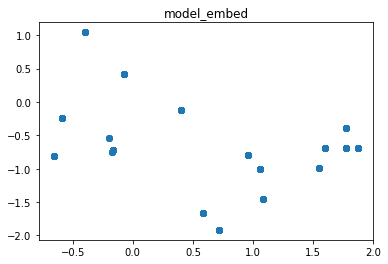

210/210 [==============================] - 0s 276us/step


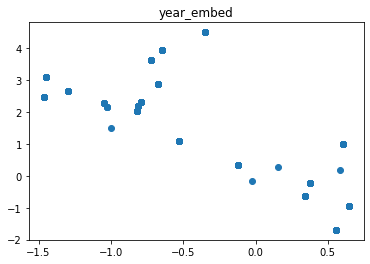

210/210 [==============================] - 0s 271us/step


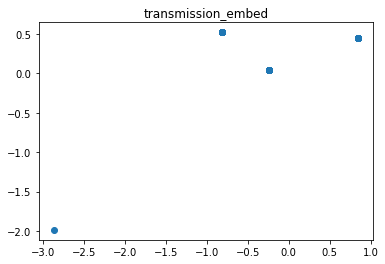

210/210 [==============================] - 0s 275us/step


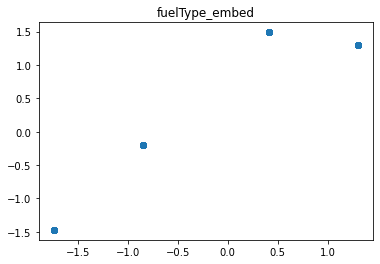

In [34]:
for categorical_header in categorical_headers:
    categorical_name = f'{categorical_header}_embed'
    every_layer_model = Model(inputs=model_3.input, outputs=model_3.get_layer(categorical_name).output)
    intermediate_output = every_layer_model.predict([X_crossed, X_cat, X_num])
    plt.title(categorical_name)
    plt.scatter(intermediate_output.T[0], intermediate_output.T[1])
    plt.show()

&emsp; t-SNE method:

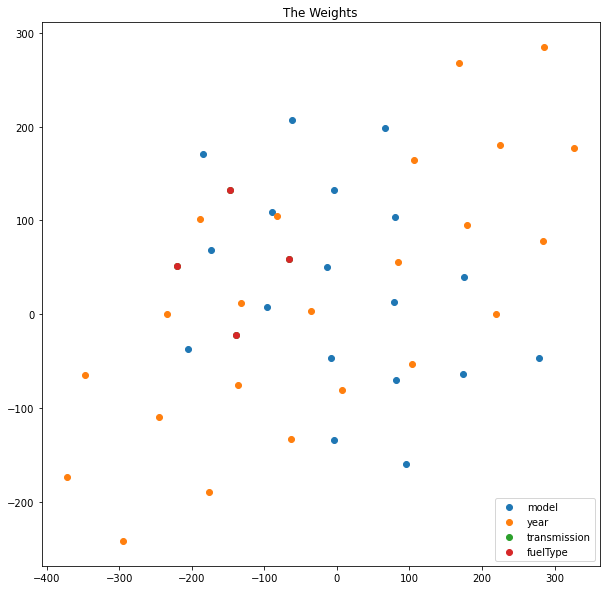

In [40]:
from sklearn.manifold import TSNE

embedded_weights = []
for layer in model_3.layers:
    if layer.name[:-6] in categorical_headers:
        embedded_weights.append(layer.get_weights())
embedded_weights = [index[0] for index in embedded_weights]

t_SNE = TSNE(perplexity = 15, random_state = 7, verbose = 0)

performed_weights = []
for embedded_weight in embedded_weights:
    t_SNE_weight = t_SNE.fit_transform(embedded_weight)
    performed_weights.append(t_SNE_weight)

plt.figure(figsize=(10,10))
for index, performed_weight in enumerate(performed_weights):    
    plt.scatter(performed_weight[:,0], 
                performed_weight[:,1], 
                label = categorical_headers[index])
plt.title('The Weights')
plt.legend(loc="lower right")
plt.show()

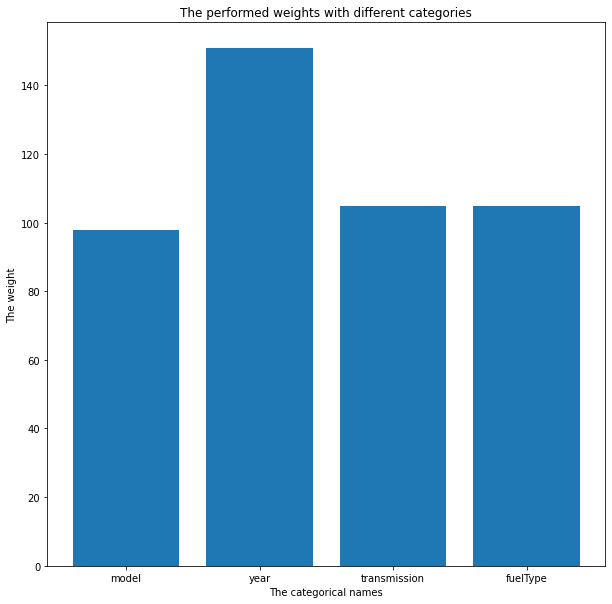

In [41]:
_, ax = plt.subplots(figsize=(10,10))

ax.set_xticks(range(len(performed_weights)))
ax.set_xticklabels(categorical_headers)
average_weight = [np.mean(np.absolute(performed_weight)) for performed_weight in performed_weights]
ax.bar(range(len(performed_weights)), average_weight)
plt.xlabel("The categorical names")
plt.ylabel("The weight")
plt.title("The performed weights with different categories")
plt.show()

&emsp; PCA method:

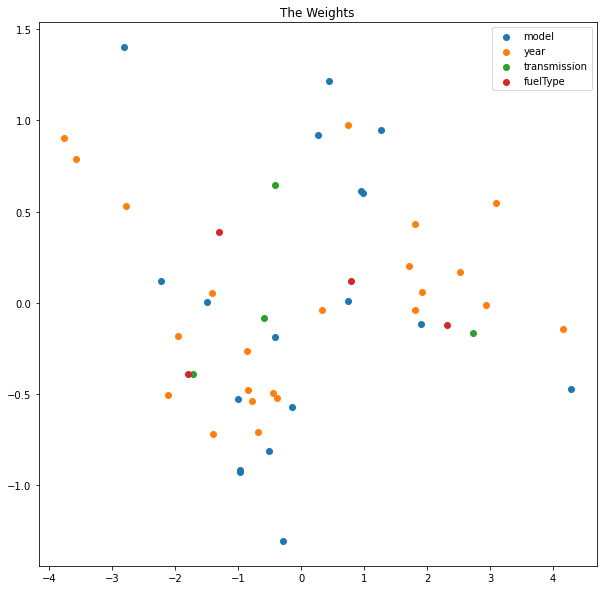

In [42]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='randomized')
pca_weights = []
for embedded_weight in embedded_weights:
    pca_weight = pca.fit_transform(embedded_weight)
    pca_weights.append(pca_weight)

plt.figure(figsize=(10,10))
for index, performed_weight in enumerate(pca_weights):    
    plt.scatter(performed_weight[:,0], 
                performed_weight[:,1], 
                label = categorical_headers[index])
plt.title('The Weights')
plt.legend()
plt.show()

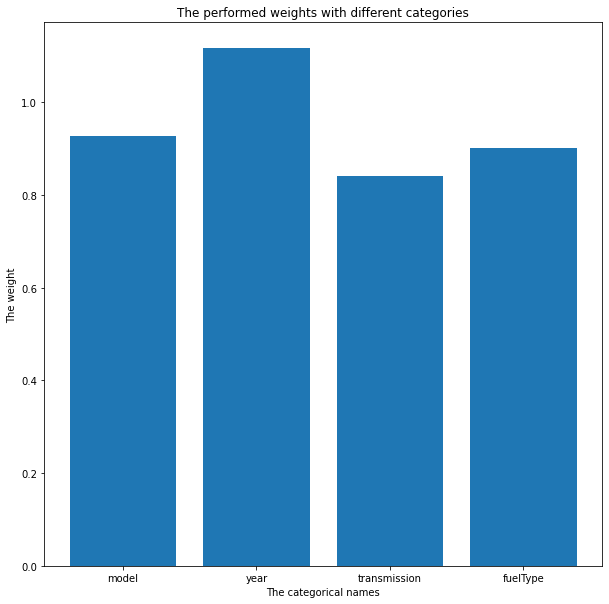

In [43]:
_, ax = plt.subplots(figsize=(10,10))

ax.set_xticks(range(len(pca_weights)))
ax.set_xticklabels(categorical_headers)
average_weight = [np.mean(np.absolute(pca_weight)) for pca_weight in pca_weights]
ax.bar(range(len(pca_weights)), average_weight)
plt.xlabel("The categorical names")
plt.ylabel("The weight")
plt.title("The performed weights with different categories")
plt.show()

&emsp; As we can see from the performed weight figures above, it is obvious that the PCA method did a better job compared to t-SNE method. Because the weights of three attributes distribute variously after using t-SNE method to perform dimensionality reduction. However, the weights of three attributes are quite similar after using PCA method to perform dimensionality reduction.